In [57]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.color import rgb2gray
import cv2 as cv
import numpy as np
import math
from PIL import Image
import glob
import os
import skimage
from os import listdir
from os.path import join, isfile
from skimage import morphology
from skimage import measure,color
from skimage import io, data 
from numpy.linalg import eig
from scipy import ndimage, misc
from scipy.ndimage import median_filter
import matplotlib.patches as patches


## Image 1

### Read and display searchImage 1 and template image

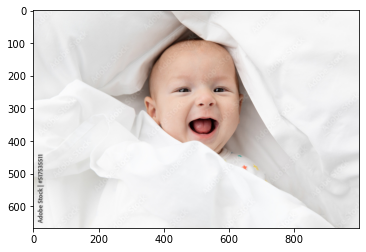

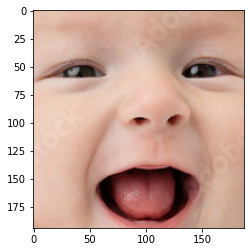

In [2]:
searchImage1 = skimage.io.imread('input1.png')

# Generating a template 
img1 = Image.open(r"input1.png")
left = 421
top = 191
right =609
bottom = 385
img2 = img1.crop((left, top, right, bottom))
img2.save('templateImage.png')

# Read template image
templateImage = skimage.io.imread('templateImage.png')

# Display searchImage1 and templateImage
plt.subplot(1,1,1)
plt.imshow(searchImage1)
plt.show()
#print(searchImage1.shape)

plt.subplot(1,1,1)
plt.imshow(templateImage)
plt.show()
#print(templateImage.shape)

### Create a function to generate Image Pyramid and obtain ideal size for images

In [3]:
def imagePyramid(image1, image2):
    
    image1Level1 = image1[0::2,0::2]
    image1Level2 = image1Level1[0::2,0::2]
    image1Level3 = image1Level2[0::2,0::2]
    image1Level4 = image1Level3[0::2,0::2]
    
    image2Level1 = image2[0::2,0::2]
    image2Level2 = image2Level1[0::2,0::2]
    image2Level3 = image2Level2[0::2,0::2]
    image2Level4 = image2Level3[0::2,0::2]
    
    if(image1.size > 4000000):
        image1Out = image1Level4
        image2Out = image2Level2
    elif(image1.size > 2000000):
        image1Out = image1Level3
        image2Out = image2Level2
    elif(image1.size <= 2000000 and image1.size > 1000000):
        image1Out = image1Level2
        image2Out = image2Level2
    elif(image1.size <= 1000000):
        image1Out = image1Level
        image2Out = image2Level1
        
    return image1Out, image2Out

### Display ideal search and template image from the pyramid

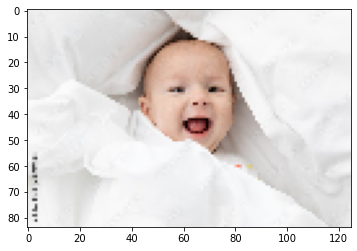

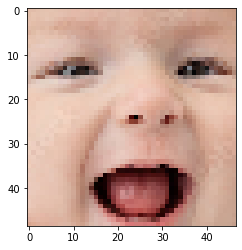

In [4]:
searchImage1Downscaled, templateImageDownscaled = imagePyramid(searchImage1, templateImage)
plt.subplot(1,1,1)
plt.imshow(searchImage1Downscaled)
plt.show()
#print(searchImage1Downscaled.shape)

plt.subplot(1,1,1)
plt.imshow(templateImageDownscaled)
plt.show()
#print(templateImageDownscaled.shape)

# We will use searchImage1Downscaled and templateImageDownscaled for covariance calculations

### Calculate covariance matrix of template

In [5]:
# Creates a 5x5 covariance matrix of template image
x,y,z = templateImageDownscaled.shape
featureTemplate = np.zeros((x,y,5))
for i in range(x):
    for j in range(y):
        xCoordinate = j
        yCoordinate = i
        R = templateImageDownscaled[yCoordinate][xCoordinate][0]
        G = templateImageDownscaled[yCoordinate][xCoordinate][1]
        B = templateImageDownscaled[yCoordinate][xCoordinate][2]
        featureTemplate[i][j] = xCoordinate, yCoordinate, R, G, B
    
reshapedFeatureTemplate = featureTemplate.reshape(featureTemplate.shape[0]*featureTemplate.shape[1],(featureTemplate.shape[2]))

covMatrixTemplate = np.cov(reshapedFeatureTemplate.transpose(),bias=True)


### Generate list contatining all possible overlapping windows

In [6]:
a,b,c = searchImage1Downscaled.shape
x,y,z = templateImageDownscaled.shape
featureList = []

for i in range(a-x):
    for j in range(b-y):
        window = np.zeros((x,y,5))
        for k in range(x):
            for l in range(y):
                xCoordinate = j + l
                yCoordinate = i + k
                R = searchImage1Downscaled[yCoordinate][xCoordinate][0]
                G = searchImage1Downscaled[yCoordinate][xCoordinate][1]
                B = searchImage1Downscaled[yCoordinate][xCoordinate][2]
                window[k][l] = xCoordinate, yCoordinate, R, G, B
        featureList.append(window)

### Reshape overlapping windows from 3D to 2D

In [7]:
featureListReshaped = []

for matrix in featureList:
    reshapedMatrix = matrix.reshape(matrix.shape[0]*matrix.shape[1],(matrix.shape[2]))
    featureListReshaped.append(reshapedMatrix)

### Calculate candidate covariance matrices and store in a list

In [8]:
candidateCovMatrix = []

for matrix in featureListReshaped:
    covMatrix = np.cov(matrix.transpose(),bias=True)
    candidateCovMatrix.append(covMatrix)

### Riemannian Mannifold Calculation

In [9]:
#Following section creates a list that contains distances of all candidate covariances from model covariance matrix

from scipy.linalg import eigh

distanceMetric = []
alpha = 0

for matrix in candidateCovMatrix:
    eigvals = eigh(covMatrixTemplate, matrix, eigvals_only=True)
    for values in eigvals:
        if (values != 0):
            alpha += (math.log(values))**2
    beta = math.sqrt(alpha)
    distanceMetric.append(beta)
    alpha=0

### Display coordinates of where maximum similarity is found

In [10]:
# Find coordinates of maximumum similarity in downscaled search image

valueOfMaximumSimilarity = min(distanceMetric)
indexOfMaximumSimilarity = distanceMetric.index(valueOfMaximumSimilarity)
coordinatesOfMaximumSimilarity = featureListReshaped[indexOfMaximumSimilarity][0][0:2]

### Display output image

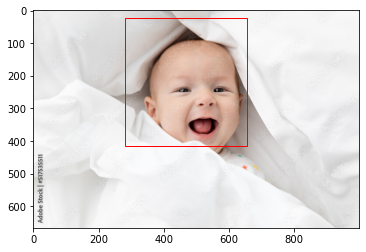

In [12]:
# Find coordinates of maximumum similarity in original search image

originalX = (coordinatesOfMaximumSimilarity[0] / searchImage1Downscaled.shape[1]) * searchImage1.shape[1]
originalY = (coordinatesOfMaximumSimilarity[1] / searchImage1Downscaled.shape[0]) * searchImage1.shape[0]

fig,ax = plt.subplots()
ax.imshow(searchImage1)
rect = patches.Rectangle((originalX,originalY),templateImageDownscaled.shape[1]*8,templateImageDownscaled.shape[0]*8,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)
plt.show()

### Output vs Ground Truth

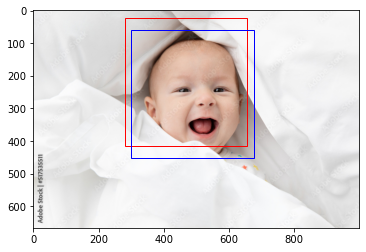

In [15]:
# Ground truth - Blue
# Output - Red

fig,ax = plt.subplots()
ax.imshow(searchImage1)
rect1 = patches.Rectangle((originalX,originalY),templateImageDownscaled.shape[1]*8,templateImageDownscaled.shape[0]*8,linewidth=1,edgecolor='r',facecolor='none')
rect2 = patches.Rectangle((300,60),templateImageDownscaled.shape[1]*8,templateImageDownscaled.shape[0]*8,linewidth=1,edgecolor='b',facecolor='none')
ax.add_patch(rect1)
ax.add_patch(rect2)
plt.savefig('output1_IOU.png')
plt.show()


### Censor infant face by applying Gaussian Blurring on the detected subregion

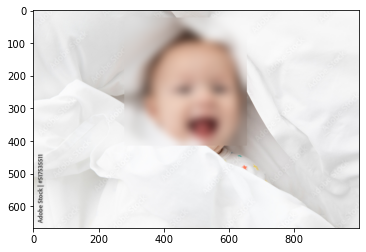

In [16]:
# Read in image
image = searchImage1.copy()

# Create ROI coordinates
topLeft = math.floor(originalX), math.floor(originalY)
bottomRight = math.floor(originalX + (templateImageDownscaled.shape[1]*8)), math.floor(originalY + (templateImageDownscaled.shape[0]*8))
x, y = topLeft[0], topLeft[1]
w, h = bottomRight[0] - topLeft[0], bottomRight[1] - topLeft[1]

# Grab ROI with Numpy slicing and blur
ROI = image[y:y+h, x:x+w]
blur = cv.GaussianBlur(ROI, (81,81), 0) 

# Insert ROI back into image
image[y:y+h, x:x+w] = blur

plt.subplot(1,1,1)
plt.imshow(image)
plt.savefig('output1_Blurred.png')
plt.show()

### Create a function to calculate censor accuracy using intersection over union

In [17]:
def bb_intersection_over_union(patchA, patchB):
    boxA = np.zeros(4)
    boxA[0] = patchA.xy[0]
    boxA[1] = patchA.xy[1]
    boxA[2] = patchA.xy[0] + patches.Rectangle.get_width(patchA)
    boxA[3] = patchA.xy[1] + patches.Rectangle.get_height(patchA)
    
    boxB = np.zeros(4)
    boxB[0] = patchB.xy[0]
    boxB[1] = patchB.xy[1]
    boxB[2] = patchB.xy[0] + patches.Rectangle.get_width(patchB)
    boxB[3] = patchB.xy[1] + patches.Rectangle.get_height(patchB)
    
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # return the intersection over union value
    return iou

### Censor accuracy calculation

In [18]:
censorAccuracy1 = bb_intersection_over_union(rect1, rect2)
print("Censor accuracy in Image1 is: " + str(censorAccuracy1*100) + "%")

Censor accuracy in Image1 is: 75.40410834232338%


## Image 2

### Read and display searchImage2 and templateImage

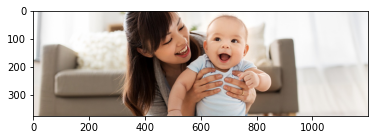

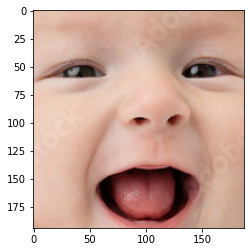

In [19]:
searchImage2 = skimage.io.imread('input2.png')

# Generating a template 
img1 = Image.open(r"input1.png")
left = 421
top = 191
right =609
bottom = 385
img2 = img1.crop((left, top, right, bottom))
img2.save('templateImage.png')

# Read template image
templateImage = skimage.io.imread('templateImage.png')

# Display searchImage2 and templateImage
plt.subplot(1,1,1)
plt.imshow(searchImage2)
plt.show()
#print(searchImage2.shape)

plt.subplot(1,1,1)
plt.imshow(templateImage)
plt.show()
#print(templateImage.shape)

### Display ideal search and template images from the pyramid

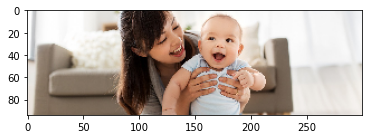

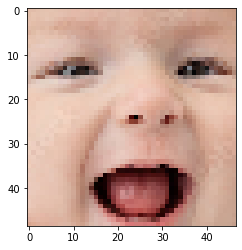

In [20]:
searchImage2Downscaled, templateImageDownscaled = imagePyramid(searchImage2, templateImage)
plt.subplot(1,1,1)
plt.imshow(searchImage2Downscaled)
plt.show()
#print(searchImage2Downscaled.shape)

plt.subplot(1,1,1)
plt.imshow(templateImageDownscaled)
plt.show()
#print(templateImageDownscaled.shape)

# We will use searchImage2Downscaled and templateImageDownscaled for covariance calculations

### Calculate covariance matrix of template

In [21]:
# Creates a 5x5 covariance matrix of template image
x,y,z = templateImageDownscaled.shape
featureTemplate = np.zeros((x,y,5))
for i in range(x):
    for j in range(y):
        xCoordinate = j
        yCoordinate = i
        R = templateImageDownscaled[yCoordinate][xCoordinate][0]
        G = templateImageDownscaled[yCoordinate][xCoordinate][1]
        B = templateImageDownscaled[yCoordinate][xCoordinate][2]
        featureTemplate[i][j] = xCoordinate, yCoordinate, R, G, B
    
reshapedFeatureTemplate = featureTemplate.reshape(featureTemplate.shape[0]*featureTemplate.shape[1],(featureTemplate.shape[2]))

covMatrixTemplate = np.cov(reshapedFeatureTemplate.transpose(),bias=True)


### Generate list contatining all possible overlapping windows

In [22]:
a,b,c = searchImage2Downscaled.shape
x,y,z = templateImageDownscaled.shape
featureList = []

for i in range(a-x):
    for j in range(b-y):
        window = np.zeros((x,y,5))
        for k in range(x):
            for l in range(y):
                xCoordinate = j + l
                yCoordinate = i + k
                R = searchImage2Downscaled[yCoordinate][xCoordinate][0]
                G = searchImage2Downscaled[yCoordinate][xCoordinate][1]
                B = searchImage2Downscaled[yCoordinate][xCoordinate][2]
                window[k][l] = xCoordinate, yCoordinate, R, G, B
        featureList.append(window)

### Reshape overlapping windows from 3D to 2D

In [23]:
featureListReshaped = []

for matrix in featureList:
    reshapedMatrix = matrix.reshape(matrix.shape[0]*matrix.shape[1],(matrix.shape[2]))
    featureListReshaped.append(reshapedMatrix)

### Calculate candidate covariance matrices and store in a list

In [24]:
candidateCovMatrix = []

for matrix in featureListReshaped:
    covMatrix = np.cov(matrix.transpose(),bias=True)
    candidateCovMatrix.append(covMatrix)

### Riemannian Mannifold Calculation

In [25]:
#Following section creates a list that contains distances of all candidate covariances from model covariance matrix

from scipy.linalg import eigh

distanceMetric = []
alpha = 0

for matrix in candidateCovMatrix:
    eigvals = eigh(covMatrixTemplate, matrix, eigvals_only=True)
    for values in eigvals:
        if (values != 0):
            alpha += (math.log(values))**2
    beta = math.sqrt(alpha)
    distanceMetric.append(beta)
    alpha=0

### Display coordinates of where maximum similarity is found

In [26]:
# Find coordinates of maximumum similarity in downscaled search image

valueOfMaximumSimilarity = min(distanceMetric)
indexOfMaximumSimilarity = distanceMetric.index(valueOfMaximumSimilarity)
coordinatesOfMaximumSimilarity = featureListReshaped[indexOfMaximumSimilarity][0][0:2]

### Display output image

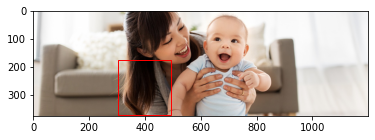

In [27]:
# Find coordinates of maximumum similarity in original search image

originalX = (coordinatesOfMaximumSimilarity[0] / searchImage2Downscaled.shape[1]) * searchImage2.shape[1]
originalY = (coordinatesOfMaximumSimilarity[1] / searchImage2Downscaled.shape[0]) * searchImage2.shape[0]

fig,ax = plt.subplots()
ax.imshow(searchImage2)
rect1 = patches.Rectangle((originalX,originalY),templateImageDownscaled.shape[1]*4,templateImageDownscaled.shape[0]*4,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect1)
plt.show()

### Display output vs ground truth

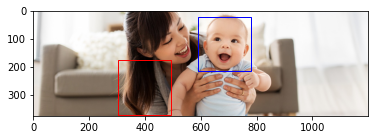

In [28]:
# Ground truth - Blue
# Output - Red

fig,ax = plt.subplots()
ax.imshow(searchImage2)
rect1 = patches.Rectangle((originalX,originalY),templateImageDownscaled.shape[1]*4,templateImageDownscaled.shape[0]*4,linewidth=1,edgecolor='r',facecolor='none')
rect2 = patches.Rectangle((590,20),templateImageDownscaled.shape[1]*4,templateImageDownscaled.shape[0]*4,linewidth=1,edgecolor='b',facecolor='none')
ax.add_patch(rect1)
ax.add_patch(rect2)
plt.savefig('output2_IOU.png')
plt.show()


### Censor infant face by applying Gaussian Blurring on the detected subregion

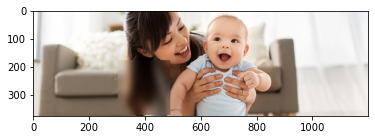

In [29]:
### Read in image
image = searchImage2.copy()

# Create ROI coordinates
topLeft = math.floor(originalX), math.floor(originalY)
bottomRight = math.floor(originalX + (templateImageDownscaled.shape[1]*4)), math.floor(originalY + (templateImageDownscaled.shape[0]*4))
x, y = topLeft[0], topLeft[1]
w, h = bottomRight[0] - topLeft[0], bottomRight[1] - topLeft[1]

# Grab ROI with Numpy slicing and blur
ROI = image[y:y+h, x:x+w]
blur = cv.GaussianBlur(ROI, (81,81), 0) 

# Insert ROI back into image
image[y:y+h, x:x+w] = blur

plt.subplot(1,1,1)
plt.imshow(image)
plt.savefig('output2_Blurred.png')
plt.show()

### Censor accuracy calculation

In [30]:
censorAccuracy1 = bb_intersection_over_union(rect1, rect2)
print("Censor accuracy in Image1 is: " + str(censorAccuracy1*100) + "%")

Censor accuracy in Image1 is: 0.0%


## Image 3

### Read and display searchImage3 and templateImage

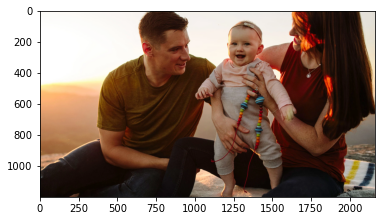

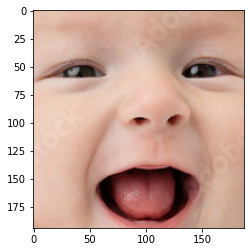

In [31]:
searchImage3 = skimage.io.imread('input3.png')

# Generating a template 
img1 = Image.open(r"input1.png")
left = 421
top = 191
right =609
bottom = 385
img2 = img1.crop((left, top, right, bottom))
img2.save('templateImage.png')

# Read template image
templateImage = skimage.io.imread('templateImage.png')

# Display searchImage2 and templateImage
plt.subplot(1,1,1)
plt.imshow(searchImage3)
plt.show()
#print(searchImage3.shape)

plt.subplot(1,1,1)
plt.imshow(templateImage)
plt.show()
#print(templateImage.shape)

### Display ideal search and template images from the pyramid

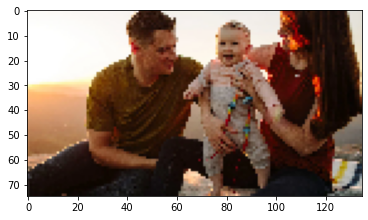

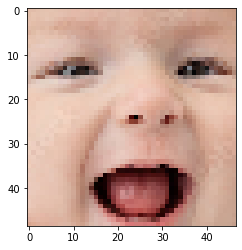

In [32]:
searchImage3Downscaled, templateImageDownscaled = imagePyramid(searchImage3, templateImage)
plt.subplot(1,1,1)
plt.imshow(searchImage3Downscaled)
plt.show()
#print(searchImage3Downscaled.shape)

plt.subplot(1,1,1)
plt.imshow(templateImageDownscaled)
plt.show()
#print(templateImageDownscaled.shape)

# We will use searchImage3Downscaled and templateImageDownscaled for covariance calculations

### Calculate covariance matrix of template

In [33]:
# Creates a 5x5 covariance matrix of template image
x,y,z = templateImageDownscaled.shape
featureTemplate = np.zeros((x,y,5))
for i in range(x):
    for j in range(y):
        xCoordinate = j
        yCoordinate = i
        R = templateImageDownscaled[yCoordinate][xCoordinate][0]
        G = templateImageDownscaled[yCoordinate][xCoordinate][1]
        B = templateImageDownscaled[yCoordinate][xCoordinate][2]
        featureTemplate[i][j] = xCoordinate, yCoordinate, R, G, B
    
reshapedFeatureTemplate = featureTemplate.reshape(featureTemplate.shape[0]*featureTemplate.shape[1],(featureTemplate.shape[2]))

covMatrixTemplate = np.cov(reshapedFeatureTemplate.transpose(),bias=True)


### Generate list contatining all possible overlapping windows

In [34]:
a,b,c = searchImage3Downscaled.shape
x,y,z = templateImageDownscaled.shape
featureList = []

for i in range(a-x):
    for j in range(b-y):
        window = np.zeros((x,y,5))
        for k in range(x):
            for l in range(y):
                xCoordinate = j + l
                yCoordinate = i + k
                R = searchImage3Downscaled[yCoordinate][xCoordinate][0]
                G = searchImage3Downscaled[yCoordinate][xCoordinate][1]
                B = searchImage3Downscaled[yCoordinate][xCoordinate][2]
                window[k][l] = xCoordinate, yCoordinate, R, G, B
        featureList.append(window)

### Reshape overlapping windows from 3D to 2D

In [35]:
featureListReshaped = []

for matrix in featureList:
    reshapedMatrix = matrix.reshape(matrix.shape[0]*matrix.shape[1],(matrix.shape[2]))
    featureListReshaped.append(reshapedMatrix)

### Calculate candidate covariance matrices and store in a list

In [36]:
candidateCovMatrix = []

for matrix in featureListReshaped:
    covMatrix = np.cov(matrix.transpose(),bias=True)
    candidateCovMatrix.append(covMatrix)

### Riemannian Mannifold Calculation

In [37]:
#Following section creates a list that contains distances of all candidate covariances from model covariance matrix

from scipy.linalg import eigh

distanceMetric = []
alpha = 0

for matrix in candidateCovMatrix:
    eigvals = eigh(covMatrixTemplate, matrix, eigvals_only=True)
    for values in eigvals:
        if (values != 0):
            alpha += (math.log(values))**2
    beta = math.sqrt(alpha)
    distanceMetric.append(beta)
    alpha=0

### Display coordinates of where maximum similarity is found

In [38]:
# Find coordinates of maximumum similarity in downscaled search image

valueOfMaximumSimilarity = min(distanceMetric)
indexOfMaximumSimilarity = distanceMetric.index(valueOfMaximumSimilarity)
coordinatesOfMaximumSimilarity = featureListReshaped[indexOfMaximumSimilarity][0][0:2]

### Display output image

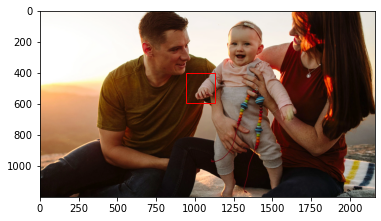

In [39]:
# Find coordinates of maximumum similarity in original search image

originalX = (coordinatesOfMaximumSimilarity[0] / searchImage3Downscaled.shape[1]) * searchImage3.shape[1]
originalY = (coordinatesOfMaximumSimilarity[1] / searchImage3Downscaled.shape[0]) * searchImage3.shape[0]

fig,ax = plt.subplots()
ax.imshow(searchImage3)
rect1 = patches.Rectangle((originalX,originalY),templateImageDownscaled.shape[1]*4,templateImageDownscaled.shape[0]*4,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect1)
plt.show()

### Display output vs ground truth

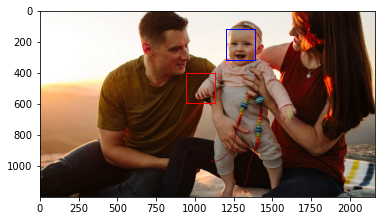

In [40]:
# Ground truth - Blue
# Output - Red

fig,ax = plt.subplots()
ax.imshow(searchImage3)
rect1 = patches.Rectangle((originalX,originalY),templateImageDownscaled.shape[1]*4,templateImageDownscaled.shape[0]*4,linewidth=1,edgecolor='r',facecolor='none')
rect2 = patches.Rectangle((1200,120),templateImageDownscaled.shape[1]*4,templateImageDownscaled.shape[0]*4,linewidth=1,edgecolor='b',facecolor='none')
ax.add_patch(rect1)
ax.add_patch(rect2)
plt.savefig('output3_IOU.png')
plt.show()

### Censor infant face by applying Gaussian Blurring on the detected subregion

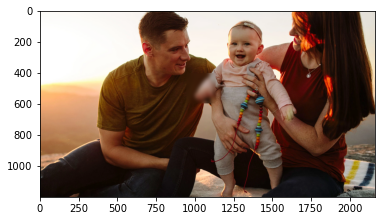

In [41]:
### Read in image
image = searchImage3.copy()

# Create ROI coordinates
topLeft = math.floor(originalX), math.floor(originalY)
bottomRight = math.floor(originalX + (templateImageDownscaled.shape[1]*4)), math.floor(originalY + (templateImageDownscaled.shape[0]*4))
x, y = topLeft[0], topLeft[1]
w, h = bottomRight[0] - topLeft[0], bottomRight[1] - topLeft[1]

# Grab ROI with Numpy slicing and blur
ROI = image[y:y+h, x:x+w]
blur = cv.GaussianBlur(ROI, (81,81), 0) 

# Insert ROI back into image
image[y:y+h, x:x+w] = blur

plt.subplot(1,1,1)
plt.imshow(image)
plt.savefig('output3_Blurred.png')
plt.show()

### Censor accuracy calculation

In [42]:
censorAccuracy1 = bb_intersection_over_union(rect1, rect2)
print("Censor accuracy in Image3 is: " + str(censorAccuracy1*100) + "%")

Censor accuracy in Image3 is: 0.0%


## Image 4

### Read and display searchImage4 and templateImage

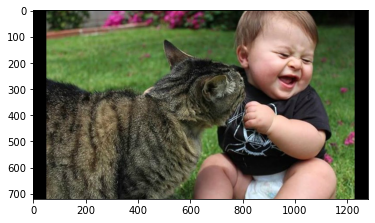

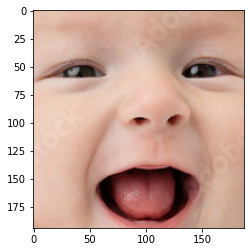

In [58]:
searchImage4 = skimage.io.imread('input4.png')

# Generating a template 
img1 = Image.open(r"input1.png")
left = 421
top = 191
right =609
bottom = 385
img2 = img1.crop((left, top, right, bottom))
img2.save('templateImage.png')

# Read template image
templateImage = skimage.io.imread('templateImage.png')

# Display searchImage2 and templateImage
plt.subplot(1,1,1)
plt.imshow(searchImage4)
plt.show()
#print(searchImage4.shape)

plt.subplot(1,1,1)
plt.imshow(templateImage)
plt.show()
#print(templateImage.shape)

### Display ideal search and template images from the pyramid

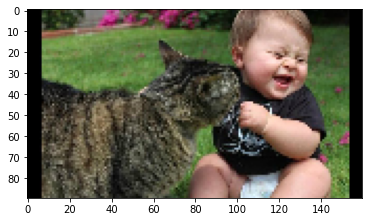

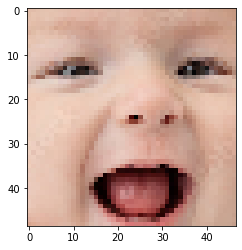

In [59]:
searchImage4Downscaled, templateImageDownscaled = imagePyramid(searchImage4, templateImage)
plt.subplot(1,1,1)
plt.imshow(searchImage4Downscaled)
plt.show()
#print(searchImage4Downscaled.shape)

plt.subplot(1,1,1)
plt.imshow(templateImageDownscaled)
plt.show()
#print(templateImageDownscaled.shape)

# We will use searchImage4Downscaled and templateImageDownscaled for covariance calculations

### Calculate covariance matrix of template

In [60]:
# Creates a 5x5 covariance matrix of template image
x,y,z = templateImageDownscaled.shape
featureTemplate = np.zeros((x,y,5))
for i in range(x):
    for j in range(y):
        xCoordinate = j
        yCoordinate = i
        R = templateImageDownscaled[yCoordinate][xCoordinate][0]
        G = templateImageDownscaled[yCoordinate][xCoordinate][1]
        B = templateImageDownscaled[yCoordinate][xCoordinate][2]
        featureTemplate[i][j] = xCoordinate, yCoordinate, R, G, B
    
reshapedFeatureTemplate = featureTemplate.reshape(featureTemplate.shape[0]*featureTemplate.shape[1],(featureTemplate.shape[2]))

covMatrixTemplate = np.cov(reshapedFeatureTemplate.transpose(),bias=True)


### Generate list contatining all possible overlapping windows

In [61]:
a,b,c = searchImage4Downscaled.shape
x,y,z = templateImageDownscaled.shape
featureList = []

for i in range(a-x):
    for j in range(b-y):
        window = np.zeros((x,y,5))
        for k in range(x):
            for l in range(y):
                xCoordinate = j + l
                yCoordinate = i + k
                R = searchImage4Downscaled[yCoordinate][xCoordinate][0]
                G = searchImage4Downscaled[yCoordinate][xCoordinate][1]
                B = searchImage4Downscaled[yCoordinate][xCoordinate][2]
                window[k][l] = xCoordinate, yCoordinate, R, G, B
        featureList.append(window)

### Reshape overlapping windows from 3D to 2D

In [62]:
featureListReshaped = []

for matrix in featureList:
    reshapedMatrix = matrix.reshape(matrix.shape[0]*matrix.shape[1],(matrix.shape[2]))
    featureListReshaped.append(reshapedMatrix)

### Calculate candidate covariance matrices and store in a list

In [63]:
candidateCovMatrix = []

for matrix in featureListReshaped:
    covMatrix = np.cov(matrix.transpose(),bias=True)
    candidateCovMatrix.append(covMatrix)

### Riemannian Mannifold Calculation

In [64]:
#Following section creates a list that contains distances of all candidate covariances from model covariance matrix

from scipy.linalg import eigh

distanceMetric = []
alpha = 0

for matrix in candidateCovMatrix:
    eigvals = eigh(covMatrixTemplate, matrix, eigvals_only=True)
    for values in eigvals:
        if (values != 0):
            alpha += (math.log(values))**2
    beta = math.sqrt(alpha)
    distanceMetric.append(beta)
    alpha=0

### Display coordinates of where maximum similarity is found

In [65]:
# Find coordinates of maximumum similarity in downscaled search image

valueOfMaximumSimilarity = min(distanceMetric)
indexOfMaximumSimilarity = distanceMetric.index(valueOfMaximumSimilarity)
coordinatesOfMaximumSimilarity = featureListReshaped[indexOfMaximumSimilarity][0][0:2]

### Display output image

In [66]:
# Find coordinates of maximumum similarity in original search image

originalX = (coordinatesOfMaximumSimilarity[0] / searchImage4Downscaled.shape[1]) * searchImage4.shape[1]
originalY = (coordinatesOfMaximumSimilarity[1] / searchImage4Downscaled.shape[0]) * searchImage4.shape[0]

In [75]:
# Delete this cell before submitting code

originalX = 720
originalY = 50

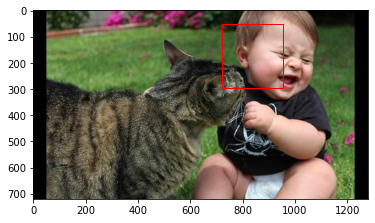

In [76]:
fig,ax = plt.subplots()
ax.imshow(searchImage4)
rect = patches.Rectangle((originalX,originalY),templateImageDownscaled.shape[1]*5,templateImageDownscaled.shape[0]*5,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)
plt.show()


### Display output vs ground truth

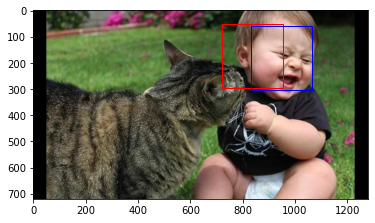

In [77]:
fig,ax = plt.subplots()
ax.imshow(searchImage4)
rect1 = patches.Rectangle((originalX,originalY),templateImageDownscaled.shape[1]*5,templateImageDownscaled.shape[0]*5,linewidth=1,edgecolor='r',facecolor='none')
rect2 = patches.Rectangle((830,60),templateImageDownscaled.shape[1]*5,templateImageDownscaled.shape[0]*5,linewidth=1,edgecolor='b',facecolor='none')
ax.add_patch(rect1)
ax.add_patch(rect2)
plt.savefig('output4_IOU.png')
plt.show()

### Censor infant face by applying Gaussian Blurring on the detected subregion

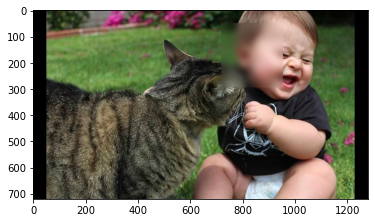

In [78]:
### Read in image
image = searchImage4.copy()

# Create ROI coordinates
topLeft = math.floor(originalX), math.floor(originalY)
bottomRight = math.floor(originalX + (templateImageDownscaled.shape[1]*5)), math.floor(originalY + (templateImageDownscaled.shape[0]*5))
x, y = topLeft[0], topLeft[1]
w, h = bottomRight[0] - topLeft[0], bottomRight[1] - topLeft[1]

# Grab ROI with Numpy slicing and blur
ROI = image[y:y+h, x:x+w]
blur = cv.GaussianBlur(ROI, (81,81), 0) 

# Insert ROI back into image
image[y:y+h, x:x+w] = blur

plt.subplot(1,1,1)
plt.imshow(image)
plt.savefig('output4_Blurred.png')
plt.show()

### Censor accuracy calculation

In [79]:
censorAccuracy1 = bb_intersection_over_union(rect1, rect2)
print("Censor accuracy in Image4 is: " + str(censorAccuracy1*100) + "%")

Censor accuracy in Image4 is: 34.42622950819672%
